<h1 align="center"> NLP: SPAM Detector </h1>

<img src="https://venturebeat.com/wp-content/uploads/2018/09/natural-language-processing-e1572968977211.jpg" width="50%" />

Created: 2020-09-01

Last updated: 2020-09-01

Kaggle Kernel made by 🚀 <a href="https://www.kaggle.com/rafanthx13"> Rafael Morais de Assis</a>

## Problem Description

Kaggle DataSet Link: https://www.kaggle.com/uciml/sms-spam-collection-dataset

**References**

https://www.kaggle.com/faressayah/natural-language-processing-nlp-for-beginners

+ Strategie1: NN
  - 0.97; 0.94
+ Strategie2: LogisticRegression TD-IDF
  - 0.98; 0.95

## Table Of Content (TOC) <a id="top"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

import re # regex

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Configs
pd.options.display.float_format = '{:,.4f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn')
seed = 42
np.random.seed(seed)

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
file_path = '/kaggle/input/sms-spam-collection-dataset/spam.csv'
df = pd.read_csv(file_path, encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

print("DataSet = {} rows and {} columns".format(df.shape[0], df.shape[1]))
print("Columns:", df.columns.tolist())
df.head()

DataSet = 5572 rows and 2 columns
Columns: ['label', 'message']


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Snippets

In [3]:
def eda_categ_feat_desc_plot(series_categorical, title = ""):
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    
    fig, ax = plt.subplots(figsize = (12,4), ncols=2, nrows=1) # figsize = (width, height)
    if(title != ""):
        fig.suptitle(title, fontsize=18)
        fig.subplots_adjust(top=0.8)

    s = sns.barplot(x=series_name, y='quantity', data=val_concat, ax=ax[0])
    for index, row in val_concat.iterrows():
        s.text(row.name, row['quantity'], row['quantity'], color='black', ha="center")

    s2 = val_concat.plot.pie(y='percentage', autopct=lambda value: '{:.2f}%'.format(value),
                             labels=val_concat[series_name].tolist(), legend=None, ax=ax[1],
                             title="Percentage Plot")

    ax[1].set_ylabel('')
    ax[0].set_title('Quantity Plot')

    plt.show()

In [4]:
def plot_nn_loss_acc(history):
    fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

    # summarize history for accuracy
    axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
    axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
    axis1.set_title('Model accuracy', fontsize=16)
    axis1.set_ylabel('accuracy')
    axis1.set_xlabel('epoch')
    axis1.legend(loc='upper left')

    # summarize history for loss
    axis2.plot(history.history['loss'], label='Train', linewidth=3)
    axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
    axis2.set_title('Model loss', fontsize=16)
    axis2.set_ylabel('loss')
    axis2.set_xlabel('epoch')
    axis2.legend(loc='upper right')
    plt.show()

In [5]:
def plot_words_distribution(mydf, target_column, title='Words distribution', x_axis='Words in column'):
    # adaptade of https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc
    # def statistics
    len_name = target_column +'_len'
    mydf[len_name] = np.array(list(map(len, mydf[target_column])))
    sw = mydf[len_name]
    median = sw.median()
    mean   = sw.mean()
    mode   = sw.mode()[0]
    # figure
    fig, ax = plt.subplots()
    sns.distplot(mydf[len_name], bins=mydf[len_name].max(),
                hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
                kde_kws={"color": "black", 'linewidth': 3})
    ax.set_xlim(left=0, right=np.percentile(mydf[len_name], 95)) # Dont get outiliers
    ax.set_xlabel(x_axis)
    ymax = 0.020
    plt.ylim(0, ymax)
    # plot vertical lines for statistics
    ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
    ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
    ax.plot([median, median], [0, ymax], '--', label=f'median = {median:.2f}', linewidth=4)
    ax.set_title(title, fontsize=20)
    plt.legend()
    plt.show()

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

this_labels = ['HAM','SPAM']

def class_report(y_real, y_my_preds, name="", labels=this_labels):
    if(name != ''):
        print(name,"\n")
    print(confusion_matrix(y_real, y_my_preds), '\n')
    print(classification_report(y_real, y_my_preds, target_names=labels))

## EDA

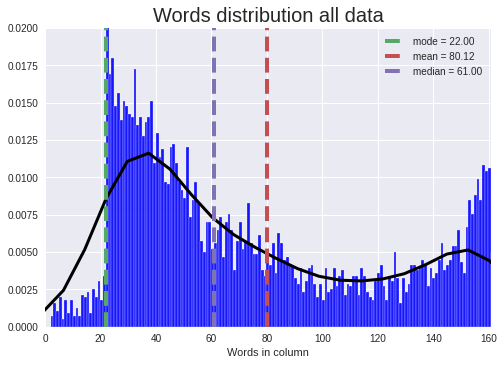

In [7]:
plot_words_distribution(df, 'message', title='Words distribution all data')

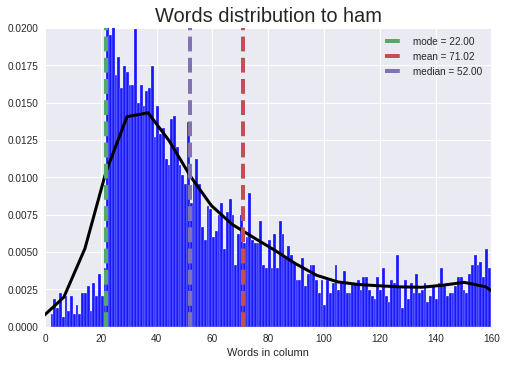

In [8]:
plot_words_distribution( df.query('label == "ham"'), 'message', title='Words distribution to ham')

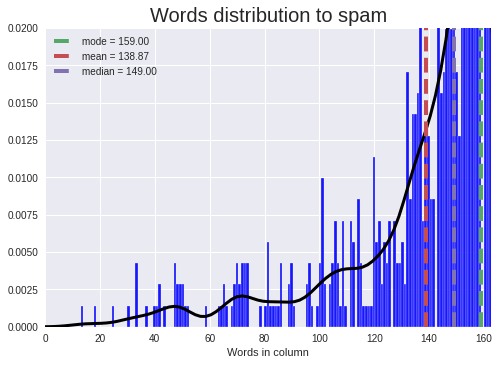

In [9]:
plot_words_distribution( df.query('label == "spam"'), 'message', title='Words distribution to spam')

In [10]:
df['message_lenght'] = np.array(list(map(len, df['message'])))

min_len = df['message_lenght'].min()
max_len = df['message_lenght'].max()

print('min len:', min_len)
print(df[df.message_lenght == min_len].message.iloc[0], '\n')

print('max len:', max_len)
print(df[df.message_lenght == max_len].message.iloc[0])

min len: 2
Ok 

max len: 910
For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


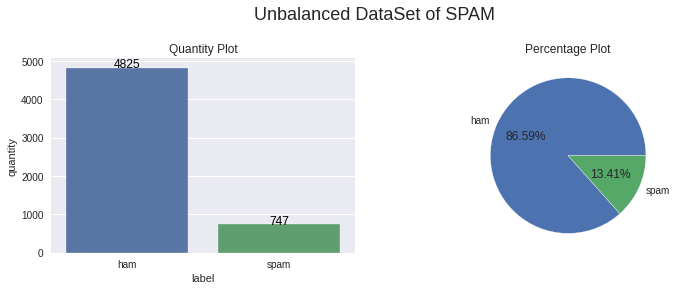

In [11]:
eda_categ_feat_desc_plot(df.label, 'Unbalanced DataSet of SPAM')

## Text Pre-Processing



### Correct some thigs

In [12]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
"couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
"hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would",
"I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
"i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
"i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
"it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
"o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
"sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
"she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
"shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
"this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
"there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
"they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
"they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
"weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
"where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
"who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
"why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
"y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
"y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will",
"you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

df['message'] = df['message'].apply(lambda x: clean_contractions(x, contraction_mapping))

In [13]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora',
'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate',
"mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist',
'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

df['message'] = df['message'].apply(lambda x: correct_spelling(x, mispell_dict))

In [14]:
df['message'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

### Remove invalid charactres, lowe and remove stop_words

In [15]:
from nltk.corpus import stopwords
import re

stops = set(stopwords.words("english"))  

def clean_message( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    #     review_text = BeautifulSoup(raw_review,).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    #     text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
                    
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [16]:
df['new_message'] = df['message'].apply(clean_message)

In [17]:
df['message'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [18]:
df['new_message'][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

### Lemmatizer/Steming

In [19]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lematizer(text):
#     text = re.sub(r'[^\w\s]','',text, re.UNICODE)
#     text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

df['new_message'] = df['new_message'].apply(lambda x: lematizer(x))

In [20]:
df['message'][5]

"FreeMsg Hey there darling it is been 3 week's now and no word back! I would like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [21]:
df['new_message'][5]

'freemsg hey darling week word back would like fun still tb ok xxx std chgs send rcv'

In [22]:
df['abc'] = df['new_message'].apply(lambda x: len(x.split(" "))).mean()

In [23]:
df['abc'][5]

8.977745872218234

In [24]:
from sklearn.model_selection import train_test_split

X = df['new_message'].values

y = df['label']
y = y.replace({'ham': 0, 'spam': 1})

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Strategie 1

imdb-review-deep-model-94-89-accuracy.html

In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

# Tokenizer
maxlen = 130
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(np.concatenate((x_train, x_test), axis=0))

# Convert x_train
list_tokenized_train = tokenizer.texts_to_sequences(x_train) # convert string to numbers, 
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # create a array of 130 spaces and put all words in end

## Convert x_test
X_tt = tokenizer.texts_to_sequences(x_test)
X_tt = pad_sequences(X_tt, maxlen=maxlen)

In [59]:
print(list_tokenized_train[0], '\n')
print(X_t[0])

[1186, 104, 795, 114, 32, 3248, 239, 2286, 424, 114, 4, 83, 3249, 112, 3250, 496, 1337, 36, 146] 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 1186
  104  795  114   32 3248  239 2286  424  114    4   83 3249  112 3250
  496 1337   36  146]


In [60]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 5
history = model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, validation_data=(X_tt, y_test))

Epoch 1/5
32/32 [==============================] - 5s 141ms/step - loss: 0.5034 - accuracy: 0.8468 - val_loss: 0.3711 - val_accuracy: 0.8654
Epoch 2/5
32/32 [==============================] - 4s 120ms/step - loss: 0.3043 - accuracy: 0.8769 - val_loss: 0.1705 - val_accuracy: 0.9679
Epoch 3/5
32/32 [==============================] - 4s 125ms/step - loss: 0.0870 - accuracy: 0.9840 - val_loss: 0.0821 - val_accuracy: 0.9756
Epoch 4/5
32/32 [==============================] - 4s 117ms/step - loss: 0.0283 - accuracy: 0.9958 - val_loss: 0.0673 - val_accuracy: 0.9769
Epoch 5/5
32/32 [==============================] - 4s 116ms/step - loss: 0.0159 - accuracy: 0.9974 - val_loss: 0.0729 - val_accuracy: 0.9846


In [61]:
# Test
y_pred = model.predict_classes(X_tt)

class_report(y_test, y_pred, "Strategie 1: Keras NN")

Strategie 1: Keras NN 

[[1450    3]
 [  19  200]] 

              precision    recall  f1-score   support

         HAM       0.99      1.00      0.99      1453
        SPAM       0.99      0.91      0.95       219

    accuracy                           0.99      1672
   macro avg       0.99      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



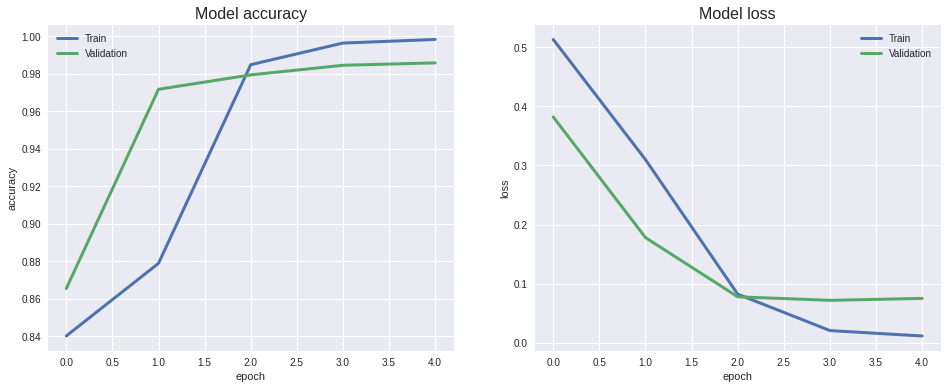

In [29]:
plot_nn_loss_acc(history)

## Strategie 2

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(np.concatenate((x_train, x_test), axis=0))

X_train_dtm = vect.transform(x_train)
X_test_dtm = vect.transform(x_test)
x_full_dtm = vect.transform( np.concatenate((x_train, x_test), axis=0) )

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit( x_full_dtm )
X_train_dtm_tfft = tfidf_transformer.transform(X_train_dtm)
X_test_dtm_tfft  = tfidf_transformer.transform(X_test_dtm)

In [31]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(C=0.5, random_state=42)
linear_svc.fit(X_train_dtm, y_train)
y_pred_class = linear_svc.predict(X_test_dtm)
print("Strategie 2: LinearSVC:\n\n", classification_report(y_test, y_pred_class, target_names=['HAM','SPAM']))

linear_svc = LinearSVC(C=0.5, random_state=42)
linear_svc.fit(X_train_dtm_tfft, y_train)
y_pred_class = linear_svc.predict(X_test_dtm_tfft)
print("Strategie 2: LinearSVC TIDF:\n\n", classification_report(y_test, y_pred_class, target_names=['HAM','SPAM']))

Strategie 2: LinearSVC:

               precision    recall  f1-score   support

         HAM       0.98      1.00      0.99      1453
        SPAM       0.99      0.86      0.92       219

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Strategie 2: LinearSVC TIDF:

               precision    recall  f1-score   support

         HAM       0.98      1.00      0.99      1453
        SPAM       0.98      0.83      0.90       219

    accuracy                           0.98      1672
   macro avg       0.98      0.91      0.94      1672
weighted avg       0.98      0.98      0.98      1672



In [32]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

print("Strategie 2: MultinomialNB:\n\n", classification_report(y_test, y_pred_class, target_names=['HAM','SPAM']))

nb = MultinomialNB()
nb.fit(X_train_dtm_tfft, y_train)
y_pred_class = nb.predict(X_test_dtm_tfft)

print("Strategie 2: MultinomialNB TIDF:\n\n", classification_report(y_test, y_pred_class, target_names=['HAM','SPAM']))

Strategie 2: MultinomialNB:

               precision    recall  f1-score   support

         HAM       0.99      0.98      0.99      1453
        SPAM       0.88      0.93      0.90       219

    accuracy                           0.97      1672
   macro avg       0.93      0.96      0.94      1672
weighted avg       0.98      0.97      0.97      1672

Strategie 2: MultinomialNB TIDF:

               precision    recall  f1-score   support

         HAM       0.96      1.00      0.98      1453
        SPAM       0.99      0.70      0.82       219

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_test)
print("Strategie 2: MultinomialNB Pipeline:\n\n", classification_report(y_test, y_pred, target_names=['HAM','SPAM']))

Strategie 2: MultinomialNB Pipeline:

               precision    recall  f1-score   support

         HAM       0.96      1.00      0.98      1453
        SPAM       0.99      0.71      0.83       219

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
print("Strategie 2: LogisticRegression :\n\n", classification_report(y_test, y_pred_class, target_names=['HAM','SPAM']))

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_dtm_tfft, y_train)
y_pred_class = logreg.predict(X_test_dtm_tfft)
print("Strategie 2: LogisticRegression TIDF:\n\n", classification_report(y_test, y_pred_class, target_names=['HAM','SPAM']))

Strategie 2: LogisticRegression :

               precision    recall  f1-score   support

         HAM       0.98      1.00      0.99      1453
        SPAM       0.99      0.84      0.91       219

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Strategie 2: LogisticRegression TIDF:

               precision    recall  f1-score   support

         HAM       0.95      1.00      0.97      1453
        SPAM       0.96      0.67      0.79       219

    accuracy                           0.95      1672
   macro avg       0.96      0.83      0.88      1672
weighted avg       0.95      0.95      0.95      1672



In [35]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(X_train_dtm, y_train)
y_pred = forest.predict(X_test_dtm)

class_report(y_test, y_pred, 'Strategie 2: RandomForestClassifier VetCount:')


forest = RandomForestClassifier() 
forest = forest.fit(X_train_dtm_tfft, y_train)
y_pred = forest.predict(X_test_dtm_tfft)
class_report(y_test, y_pred, 'Strategie 2: RandomForestClassifier TD-IDF')

Strategie 2: RandomForestClassifier VetCount: 

[[1453    0]
 [  40  179]] 

              precision    recall  f1-score   support

         HAM       0.97      1.00      0.99      1453
        SPAM       1.00      0.82      0.90       219

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.98      0.98      0.98      1672

Strategie 2: RandomForestClassifier TD-IDF 

[[1452    1]
 [  36  183]] 

              precision    recall  f1-score   support

         HAM       0.98      1.00      0.99      1453
        SPAM       0.99      0.84      0.91       219

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



## Strategie 3

approaches-of-nlp-and-sentiment-classification.html

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Masking, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 400
maxlen = 200
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(x_train)
X_train_token = tokenizer.texts_to_sequences(x_train)

tokenizer.fit_on_texts(x_test)
X_test_token = tokenizer.texts_to_sequences(x_test)

XX_train = pad_sequences(X_train_token, maxlen=maxlen, padding='post')
XX_test  = pad_sequences(X_test_token, maxlen=maxlen, padding='post')

model = Sequential([Embedding(max_features, 64, mask_zero=True),
                    Bidirectional(LSTM(64, dropout=0.2)),
                    Dense(64, activation='sigmoid'),
                    Dense(1)])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(XX_train, y_train,
                    batch_size=50,
                    epochs=5,
                    validation_data=(XX_test, y_test))

Epoch 1/5
78/78 [==============================] - 17s 215ms/step - loss: 0.8987 - accuracy: 0.4585 - val_loss: 1.3442 - val_accuracy: 0.6728
Epoch 2/5
78/78 [==============================] - 14s 182ms/step - loss: 0.2570 - accuracy: 0.9174 - val_loss: 1.5742 - val_accuracy: 0.7368
Epoch 3/5
78/78 [==============================] - 14s 183ms/step - loss: 0.1502 - accuracy: 0.9400 - val_loss: 1.5631 - val_accuracy: 0.7452
Epoch 4/5
78/78 [==============================] - 14s 180ms/step - loss: 0.1161 - accuracy: 0.9633 - val_loss: 1.7089 - val_accuracy: 0.7793
Epoch 5/5
78/78 [==============================] - 15s 187ms/step - loss: 0.1012 - accuracy: 0.9810 - val_loss: 2.0965 - val_accuracy: 0.7817


In [37]:
y_pred = model.predict_classes(XX_test)

print("Strategie 3: Keras NN: \n", classification_report(y_test, y_pred, target_names=['HAM','SPAM']))

Strategie 3: Keras NN: 
               precision    recall  f1-score   support

         HAM       0.87      0.89      0.88      1453
        SPAM       0.10      0.08      0.09       219

    accuracy                           0.78      1672
   macro avg       0.48      0.48      0.48      1672
weighted avg       0.76      0.78      0.77      1672



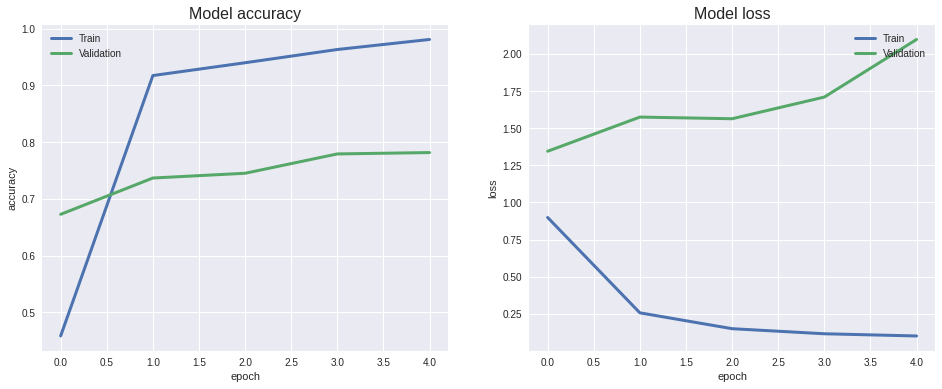

In [38]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

## Strategie 4

google-movie-reviews-sentiment-deep-stack-models.html

In [39]:
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

maxlen = 370
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 32
epochs = 3
history = model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/3
98/98 [==============================] - 20s 200ms/step - loss: 0.3680 - accuracy: 0.8772 - val_loss: 0.1325 - val_accuracy: 0.9654
Epoch 2/3
98/98 [==============================] - 18s 181ms/step - loss: 0.0574 - accuracy: 0.9862 - val_loss: 0.0756 - val_accuracy: 0.9731
Epoch 3/3
98/98 [==============================] - 19s 189ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0748 - val_accuracy: 0.9782


In [44]:
y_pred = model.predict(X_te)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

class_report(y_test, y_pred, 'Strategie 4: Keras NN:')

Strategie 4: Keras NN: 

[[1445    8]
 [  17  202]] 

              precision    recall  f1-score   support

         HAM       0.99      0.99      0.99      1453
        SPAM       0.96      0.92      0.94       219

    accuracy                           0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.98      0.99      0.98      1672



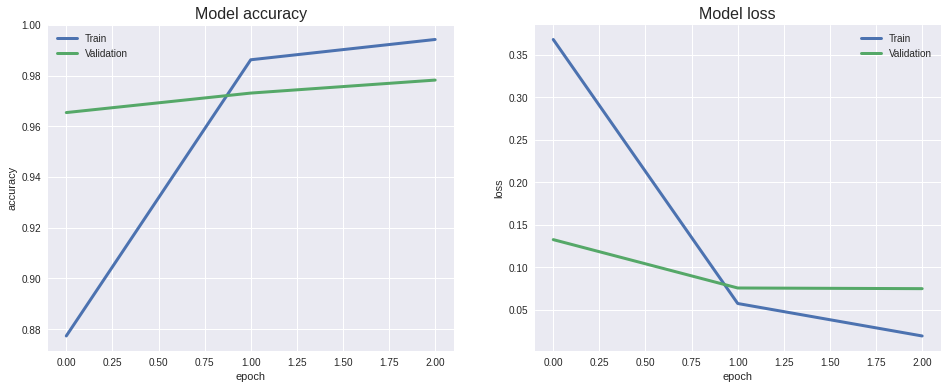

In [42]:
plot_nn_loss_acc(history)

## STRATEGIE 5

file:///home/rhavel/Downloads/kaggle/spam%20avaliation/strategies/STRATEGIE-5-imdb-review-word2vec-bilstm-99-acc.html

In [45]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, Phrases

In [46]:
from bs4 import BeautifulSoup
from nltk import word_tokenize

counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

all_reviews = np.array(list(map(lambda x: preprocess(x, len(np.concatenate((x_train, x_test)))), np.concatenate((x_train, x_test)))))
counter = 0

In [47]:
%%time
bigrams = Phrases(sentences=all_reviews)

CPU times: user 128 ms, sys: 6.02 ms, total: 134 ms
Wall time: 130 ms


In [48]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

CPU times: user 431 ms, sys: 9.51 ms, total: 441 ms
Wall time: 434 ms


In [49]:
%%time
embedding_vector_size = 256 #256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

CPU times: user 5.95 s, sys: 16.6 ms, total: 5.96 s
Wall time: 5.6 s


In [50]:
%%time

# max_features = 6000
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(x_train)
# list_tokenized_train = tokenizer.texts_to_sequences(x_train)
# list_tokenized_test = tokenizer.texts_to_sequences(x_test)

def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[all_reviews]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 1.1 s, sys: 1.35 ms, total: 1.11 s
Wall time: 1.11 s


In [51]:
XX_train, XX_test, yy_train, yy_test = train_test_split(
    X_pad,
    np.concatenate((y_train, y_test)),
    test_size=0.05,
    shuffle=True,
    random_state=42)

In [52]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 256)          636416    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,047,169
Trainable params: 410,753
Non-trainable params: 636,416
________________________________________

In [56]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=XX_train,
    y=yy_train,
    validation_data=(XX_test, yy_test),
    batch_size=100,
    epochs=2)

Epoch 1/2
53/53 [==============================] - 39s 740ms/step - loss: 0.3269 - accuracy: 0.8628 - val_loss: 0.3918 - val_accuracy: 0.8423
Epoch 2/2
53/53 [==============================] - 40s 753ms/step - loss: 0.3241 - accuracy: 0.8630 - val_loss: 0.3643 - val_accuracy: 0.8387


Strategie 5: Keras NN ULTRA TIME: 

[[234   1]
 [ 44   0]] 

              precision    recall  f1-score   support

         HAM       0.84      1.00      0.91       235
        SPAM       0.00      0.00      0.00        44

    accuracy                           0.84       279
   macro avg       0.42      0.50      0.46       279
weighted avg       0.71      0.84      0.77       279



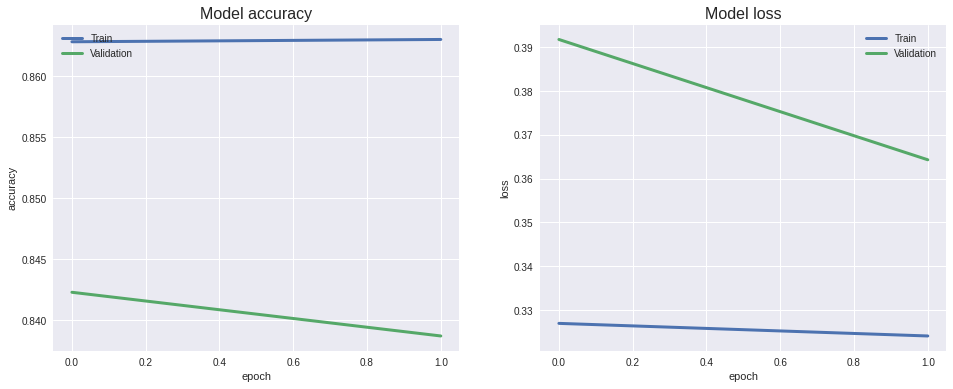

In [57]:
y_pred = model.predict_classes(XX_test)

class_report(yy_test, y_pred, 'Strategie 5: Keras NN ULTRA TIME:')

plot_nn_loss_acc(history)